In [12]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd, numpy as np
import os
from skimage import io
import torch
from torchvision import datasets, models, transforms
import torchvision
from skimage import color


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, num_epochs=25, trainVal=['train','val'],verbose=True):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss2plot = np.zeros([2,num_epochs])
    acc2plot  = np.zeros([2,num_epochs])

    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in trainVal:
            if phase == 'train':
                imageLoader = train_loader
            else:
                imageLoader = validation_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in imageLoader:
                # get the inputs
                inputs = sample_batched['x']
                labels = sample_batched['y']

                # wrap them in Variable
                if use_gpu:
                    inputs = inputs.type(torch.FloatTensor).cuda()
                    labels = labels.type(torch.FloatTensor).cuda()
                else:
                    inputs, labels = inputs.type(torch.FloatTensor), labels.type(torch.FloatTensor)
                
                labels = labels.view(-1,1)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                preds = torch.round(outputs.data)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                loss2plot[0,epoch] = epoch_loss
                acc2plot[0,epoch] = epoch_acc
            else:
                loss2plot[1,epoch] = epoch_loss
                acc2plot[1,epoch] = epoch_acc
                    
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        if verbose:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    for phase in trainVal:
        if phase == 'train':
            idx=0
        else:
            idx=1
            
        fig = plt.figure()
        a = fig.add_subplot(2,2,2*idx+1)
        plt.plot(loss2plot[idx,:])
        plt.title('Loss per epoch for ' + phase)

        a = fig.add_subplot(2,2,2*idx+2)
        plt.plot(acc2plot[idx,:])
        plt.title('Accuracy per epoch for ' + phase)
        plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

from torch.nn import init
def init_weights(module):
    #Optional: Initialize weights using Xavier Initialization 
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform_(param.data, 1)
            else:
                init.xavier_uniform_(param.data)
        elif name.find('bias') != -1:
            init.constant_(param.data, 0)



In [25]:
model_resnet = torchvision.models.resnet34(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = torch.nn.Linear(num_ftrs, 1)

In [26]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([256,256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
class HXrayDataset_TL(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        #some cases io.imread brings more channels than 1 due to bitsize issues
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]
            
        # replicate the image into 3 RGB channels
        image=np.repeat(image[None,...],3,axis=0)
            
        image_age = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'x': image, 'y': image_age}

        return sample


In [27]:
BATCH_SIZE = 16

HXray_TrainData = HXrayDataset_TL(csv_file='data/random_train_boneage.csv',
                                    root_dir='/beegfs/ga4493/projects/team_G/images', transform=train_transform)
train_loader = DataLoader(HXray_TrainData, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=0)

HXray_ValidationData = HXrayDataset_TL(csv_file='data/random_validation_boneage.csv',
                                    root_dir='/beegfs/ga4493/projects/team_G/images', transform=validation_transform)
validation_loader = DataLoader(HXray_ValidationData, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

dataset_sizes = {'train': len(HXray_TrainData), 'val': len(HXray_ValidationData)}


Training complete in 264m 23s
Best val Acc: 0.039370


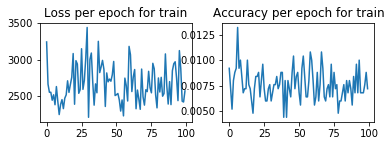

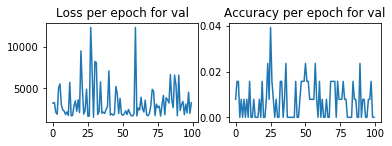

In [28]:
if use_gpu:
    model_resnet = model_resnet.cuda()
     #This will optimize only the final layer since other layers the gradient calculation is removed and only parameters from the fc layer is given to the optimizer
    optimizer = torch.optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)

criterion = torch.nn.MSELoss()

model_resnet.train()   
model_resnet_sub = train_model(model_resnet, criterion, optimizer,
                       num_epochs=100, trainVal=['train','val'],verbose=False)